In [ ]:
#%matplotlib notebook
#%matplotlib inline
#matplotlib.interactive(True)
%gui qt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
from matplotlib import cm

from IPython.display import HTML
import pandas as pd
import numpy as np
import math
import cmath
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
import matplotlib.animation as animation
import json
import ipyvolume as ipv
import vtk
from mayavi import mlab
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits  
from random import uniform, shuffle
from pyquaternion import Quaternion

def make_rand_vector(dims):
    vec = [uniform(-1, 1) for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return [x/mag for x in vec]

def best_angle(rot_i,qA,qB):
    qRot = Quaternion(0,0,0,0)
    qRot[rot_i] = 1
    qC = qB * qRot
    qdist = qA[0]*qC[0] + qA[1]*qC[1] +qA[2]*qC[2] +qA[3]*qC[3]
    qRot[rot_i] = -1
    qC = qB * qRot
    qdist = max(qdist, qA[0]*qC[0] + qA[1]*qC[1] +qA[2]*qC[2] +qA[3]*qC[3])
    return qdist
    #return 2*qdist**2-1

In [2]:
#Open Files
directory = 'DCT_Final_VF/'
infile = ['z10.fits','z9.4.fits','z8.4.fits','z7.4.fits']
outfile = ['outz10.fits', 'outz9.4.fits', 'outz8.4.fits', 'outz7.4.fits']
array=[]
with open('DCT_Final_VF/res/lvec.txt') as f:
    next(f)
    for line in f:
        for val in line.split():
            array.append(int(val))
myarray = np.asarray(array[1:])
               
hduin  = fits.open(directory+infile[0])[0]
hduout = fits.open(directory+outfile[0])[0]

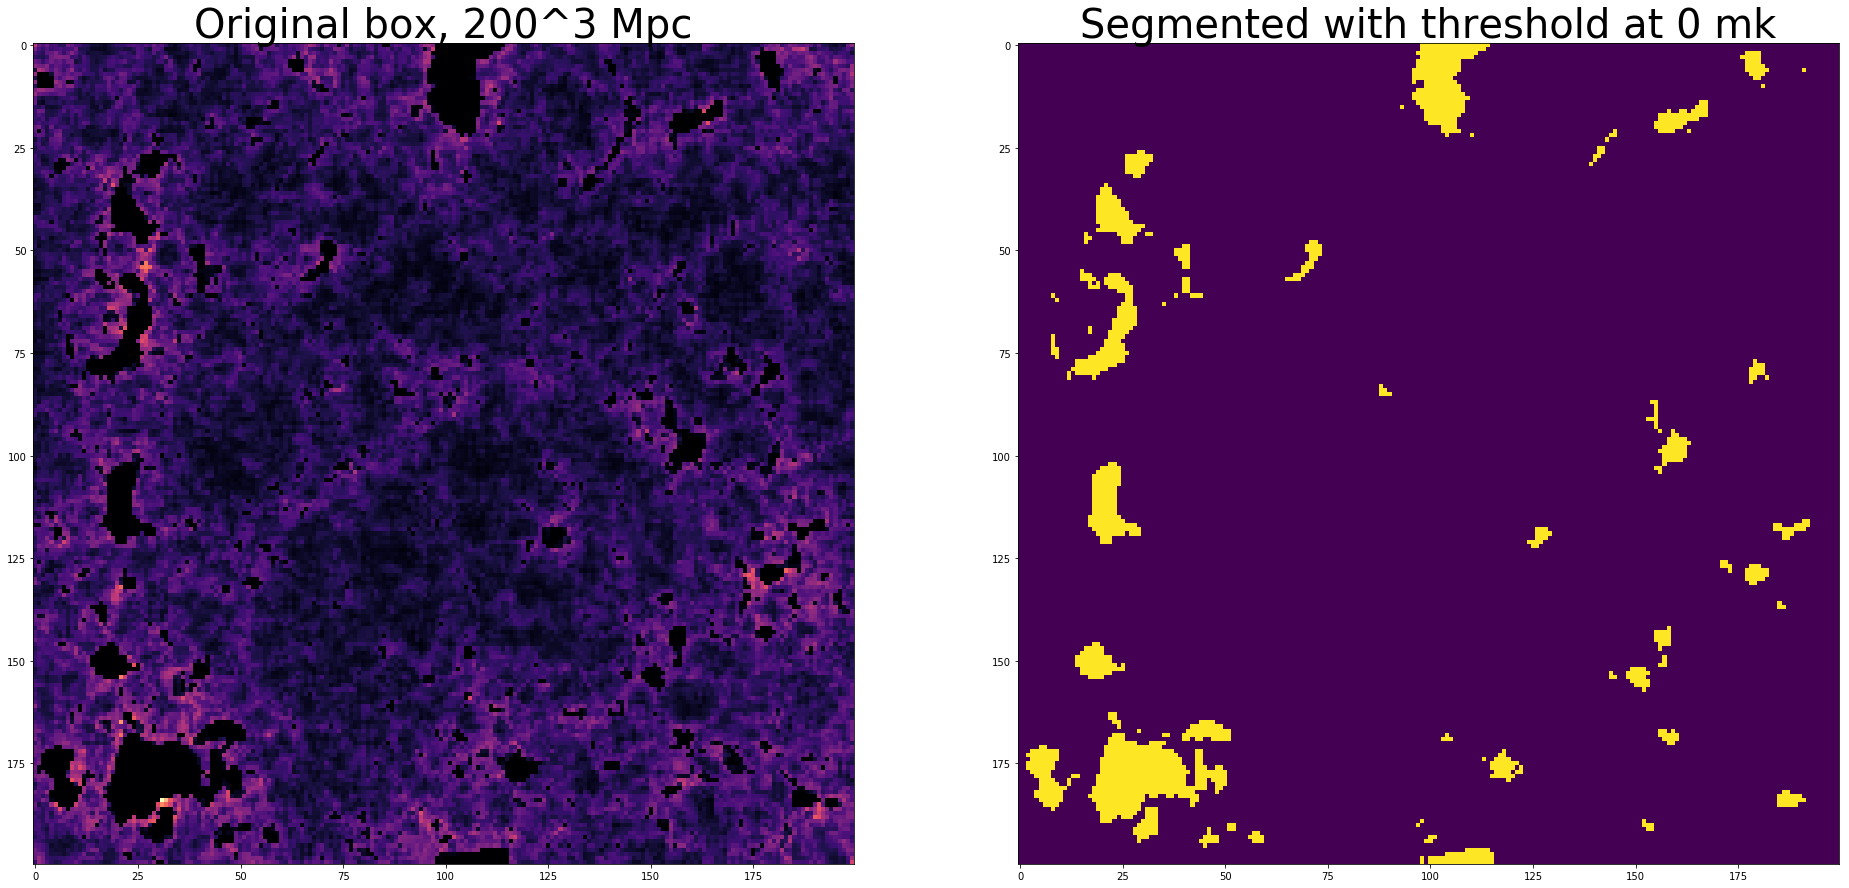

In [4]:
#Plot files
plt.figure(figsize=(50,50))
plt.axis('off')
plt.subplot(1, 3, 1)
plt.title('Original box, 200^3 Mpc', fontsize=40)
plt.imshow(hduin.data[:,:,5], cmap='magma')
plt.subplot(1, 3, 2)
plt.title('Segmented with threshold at 0 mk', fontsize=40)
plt.imshow(hduout.data[:,:,5])

In [ ]:
#VIZU IPVQUICK
ipv.quickvolshow(hduout.data, level=[0, 1], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.show()

In [6]:
#Vizu mlab
s = hduin.data
mlab.contour3d(s, opacity = 0.05)
mlab.show()

In [ ]:
#Mosaic

show_m_mosaic = window.ShowManager(renderer, size=(120, 90))
show_m_mosaic.initialize()

result_position = ui.TextBlock2D(text='')
result_value = ui.TextBlock2D(text='')

renderer.clear()
renderer.projection('parallel')

result_position.message = ''
result_value.message = ''


def left_click_callback_mosaic(obj, ev):
    """Get the value of the clicked voxel and show it in the panel."""
    event_pos = show_m_mosaic.iren.GetEventPosition()

    obj.picker.Pick(event_pos[0],event_pos[1], 0, show_m_mosaic.ren)

    i, j, k = obj.picker.GetPointIJK()
    result_position.message = '({}, {}, {})'.format(str(i), str(j), str(k))
    result_value.message = '%.8f' % data[i, j, k]
    
cnt = 0

X, Y, Z = slice_actor.shape[:3]

rows = 10
cols = 15
border = 10

for j in range(rows):
    for i in range(cols):
        slice_mosaic = slice_actor.copy()
        slice_mosaic.display(None, None, cnt)
        slice_mosaic.SetPosition((X + border) * i,
                                 0.5 * cols * (Y + border) - (Y + border) * j,
                                 0)
        slice_mosaic.SetInterpolate(False)
        slice_mosaic.AddObserver('LeftButtonPressEvent', left_click_callback_mosaic, 1.0)
        renderer.add(slice_mosaic)
        cnt += 1
        if cnt > Z:
            break
    if cnt > Z:
        break

renderer.reset_camera()
renderer.zoom(1.6)

#show_m_mosaic.ren.add(panel_picking)
#show_m_mosaic.start()
window.record(renderer, out_path='mosaic.png', size=(900, 600),         reset_camera=False)

%%latex
{STATS}
\begin{equation}
I(O)
=
\begin{bmatrix}
    I(O)_{xx}   & I(O)_{xy} & I(O)_{xz} \\
    I(O)_{yx}   & I(O)_{yy} & I(O)_{yz} \\
    I(O)_{zx}   & I(O)_{zy} & I(O)_{zz}
\end{bmatrix}
\\ \\
\end{equation}

$$ \\ $$
$$\mbox{Continuous case: } I(O)_{xx} = \iiint_O x^2\, dV\, \mbox{is consistent with}\ L^5 \\$$
$$\mbox{Discrete case as to be corrected, with a factor corresponding to the volume of a 1x1x1 pixel box}\\ $$
$$ \\ $$

\begin{align}
I(O)_{xx} & = \sum_O(x-\bar x)^2 + V(O)/12 \\
I(O)_{yy} & = \sum_O(y-\bar y)^2 + V(O)/12\\
I(O)_{zz} & = \sum_O(z-\bar z)^2 + V(O)/12\\
I(O)_{xy} & = \sum_O(x-\bar x)\times(y-\bar y) \\
I(O)_{xz} & = \sum_O(x-\bar x)\times(z-\bar z) 
\end{align}

$$ \mbox{Three eigenvalues} \quad \lambda_1 > \lambda_2 > \lambda_3 , \mbox{from which we obtain the direction length with} \quad d_i(O) = \sqrt{\frac{20|\lambda_i|}{V(O)}}$$
$$ \mbox{1. Non-compactness} : \frac{Tr(I(O))}{V^{5/3}(O)} \quad \mbox{1 for compact circular bubbles, gets higher as the object becomes less compact}$$
$$ \mbox{2. Elongation} : \frac{\lambda_1}{\lambda_2} \quad \mbox{Main axis/Second axis }$$
$$ \mbox{3. Flatness} : \frac{\lambda_2}{\lambda_3} \quad \mbox{Second axis/Third axis }$$
    
$$ \mbox{4. Sparseness} : \frac{\pi d_1d_2d_3}{6V} \quad \mbox{Ratio of the volume expected given its principal
axes, over the actual volume.}$$
$$\mbox{It attains a minimum of 1 for solid
spheres and ellipsoids, is equal to about 1.127 for solid rectangular
blocks, and becomes higher as the object becomes either
hollowed out or tree-like.}$$


/home/simon/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/simon/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/simon/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/simon/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/simon/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in divide
/home/simon/anaconda2/lib/python2.7

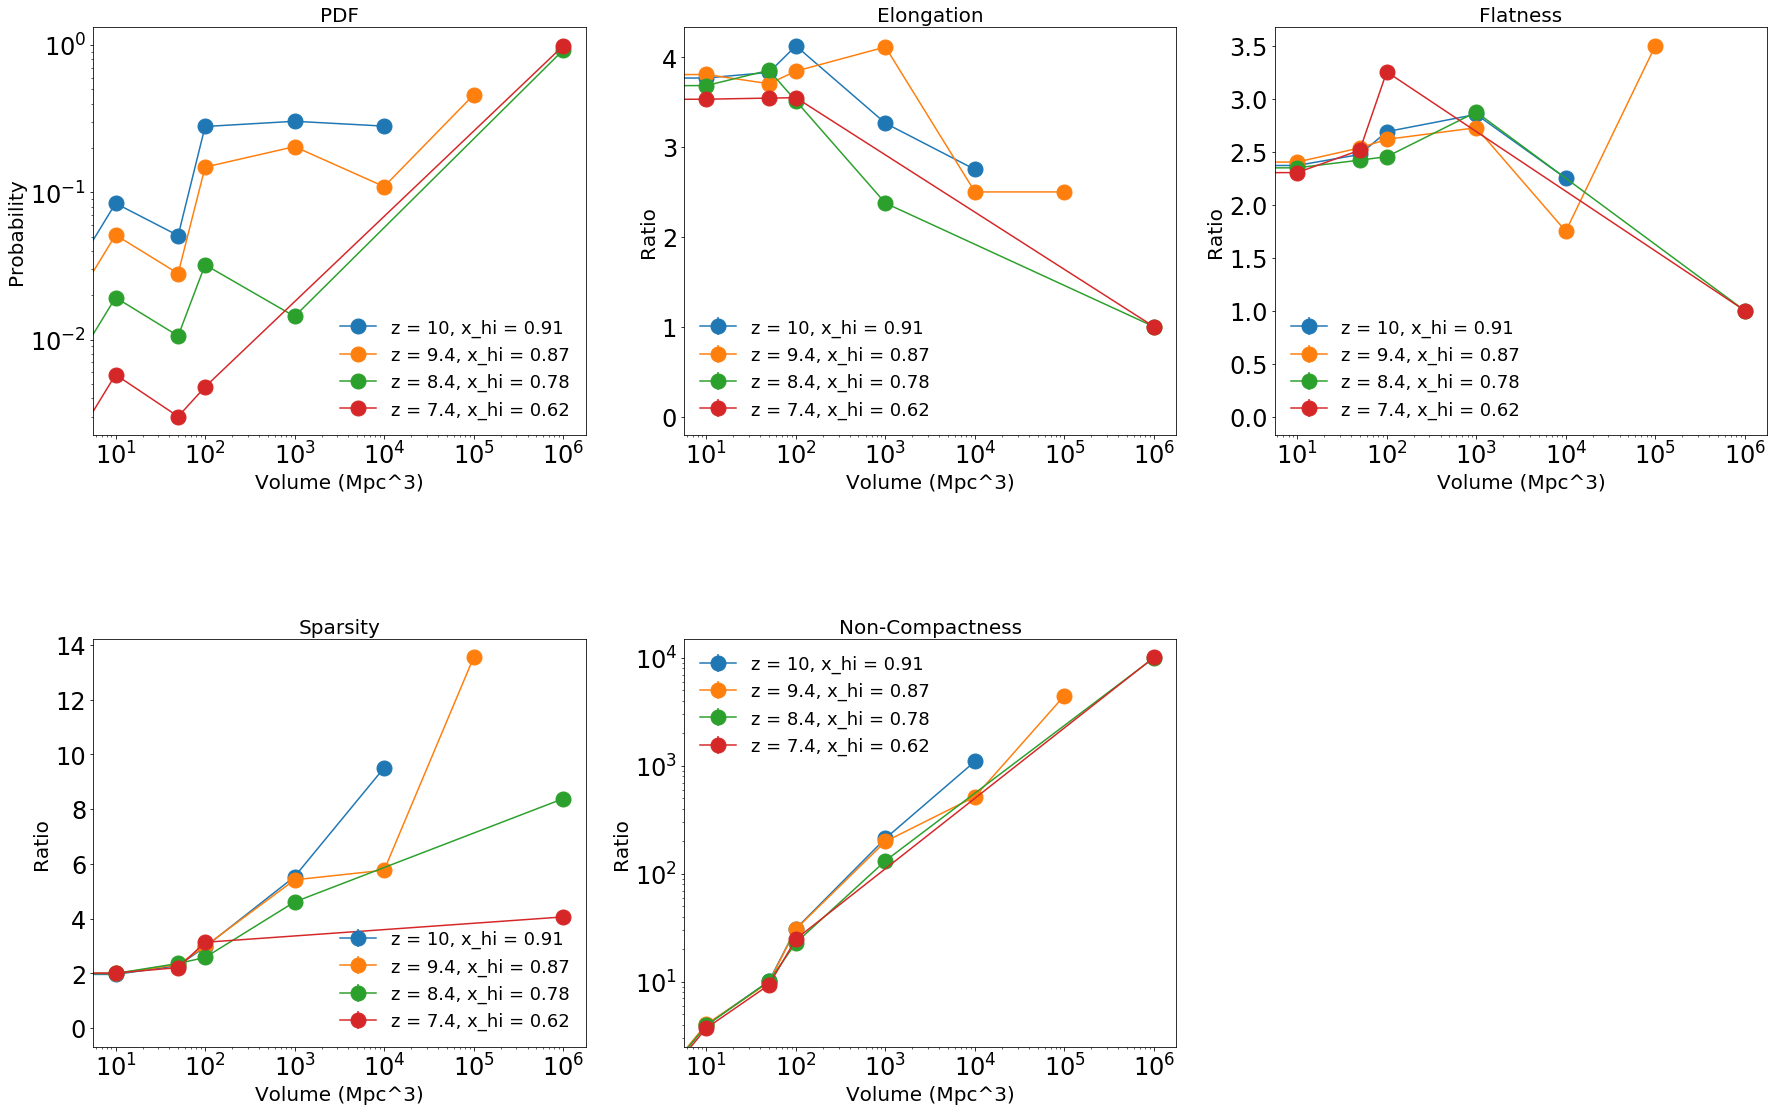

In [4]:
#plot stats
fig = plt.figure(figsize=(30,30))
plt.tick_params(axis = 'both', which = 'major', labelsize = 34)
plt.subplots_adjust(hspace=0.5)
bins=[0, 10, 25, 50, 75, 100,125,150, 175,200,250,500]
inprefix = ['z10_Inertia_Scale_','z9.4_Inertia_Scale_', 'z8.4_Inertia_Scale_', 'z7.4_Inertia_Scale_',]
mylegend = ['z = 10, x_hi = 0.91','z = 9.4, x_hi = 0.87', 'z = 8.4, x_hi = 0.78', 'z = 7.4, x_hi = 0.62']
labelsize = 20
legendsize = 20
l = 0 
line = [[None],[None],[None],[None],[None]]
for name in inprefix: 
    flat = np.zeros((array[0],2))
    elong = np.zeros((array[0],2))
    ncomp = np.zeros((array[0],2))
    spars = np.zeros((array[0],2))
    pattern = np.zeros((array[0]))

    var   = []
    for i in range (0,array[0]):
        with open('DCT_Final_VF/out/'+name+str(array[i+1])+'.txt') as f:
            var.append(json.load(f))
    j=1
    center = []
    all_f =[]
    all_e =[]
    all_n =[]
    all_s =[]
    while j < array[0]:
        temp_f= []
        temp_e= []
        temp_n= []
        temp_s = []
        for elements in var[j]:
            temp_f.append(elements["flat"])
            temp_e.append(elements["elong"])
            temp_n.append(elements["ncomp"])
            temp_s.append(elements["spars"])
            all_f.append(elements["flat"])
            all_e.append(elements["elong"])
            all_n.append(elements["ncomp"])
            all_s.append(elements["spars"])
            center.append(elements["center"])
            pattern[j] += elements["volume"]
        flat[j]  = [np.mean(temp_f),np.std(temp_f)]
        elong[j] = [np.mean(temp_e),np.std(temp_e)]
        ncomp[j] = [np.mean(temp_n),np.std(temp_n)]
        spars[j] = [np.mean(temp_s),np.std(temp_s)]
        j+=1

    center = np.array(center)
    
    myarray = np.asarray(array[1:])
    col = np.zeros(len(myarray))
    mask = np.isfinite(spars[:,0]) # Log_1a is column 2 data points
        
    ax = plt.subplot(3, 3, 1)#wcs = WCS(hdu.header)
    plt.xlabel('Volume (Mpc^3)', fontsize=labelsize)
    plt.ylabel('Probability', fontsize=labelsize)
    plt.title('PDF', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    plt.loglog(myarray[mask], pattern[mask]/np.sum(pattern[mask]),linestyle ="-", marker ="o", markersize=15)
    ax.legend(labels = mylegend, loc = 'lower right', fontsize=18, frameon=False )

    
    ax = plt.subplot(3, 3, 2)
    plt.xlabel('Volume (Mpc^3)', fontsize=labelsize)
    plt.ylabel('Ratio', fontsize=labelsize)
    plt.title('Elongation', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.errorbar(myarray[mask], elong[mask,0], elong[mask,1]/np.sqrt(col[mask]), fmt='o', markersize=15, linestyle ="-")
    ax.legend(labels = mylegend, loc = 'lower left', fontsize=18, frameon=False )
    
    ax = plt.subplot(3, 3, 3)
    plt.xlabel('Volume (Mpc^3)', fontsize=labelsize)
    plt.ylabel('Ratio', fontsize=labelsize)
    plt.title('Flatness', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.errorbar(myarray[mask], flat[mask,0], flat[mask,1]/np.sqrt(col[mask]), fmt='o', markersize=15, linestyle ="-")
    ax.legend(labels = mylegend, loc = 'lower left', fontsize=18, frameon=False )

    ax = plt.subplot(3, 3, 4)
    plt.xlabel('Volume (Mpc^3)', fontsize=labelsize)
    plt.ylabel('Ratio', fontsize=labelsize)
    plt.title('Sparsity', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.errorbar(myarray[mask], spars[mask,0], spars[mask,1]/np.sqrt(col[mask]), fmt='o', markersize=15, linestyle ="-")
    ax.legend(labels = mylegend, loc = 'lower right', fontsize=18, frameon=False )

    plt.subplot(3, 3, 5)
    plt.xlabel('Volume (Mpc^3)', fontsize=labelsize)
    plt.ylabel('Ratio', fontsize=labelsize)
    plt.title('Non-Compactness', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.errorbar(myarray[mask], ncomp[mask,0], ncomp[mask,1]/np.sqrt(col[mask]), fmt='o', markersize=15, linestyle ="-")
    ax.legend(labels = mylegend, loc = 'upper left', fontsize=18, frameon=False )

    

In [ ]:
#plot stats radis
fig = plt.figure(figsize=(30,30))
plt.tick_params(axis = 'both', which = 'major', labelsize = 34)
plt.subplots_adjust(hspace=0.5)
bins=[0, 10, 25, 50, 75, 100,125,150, 175,200,250,500]
inprefix = ['z10_Inertia_Scale_','z9.4_Inertia_Scale_', 'z8.4_Inertia_Scale_', 'z7.4_Inertia_Scale_',]
mylegend = ['z = 10, x_hi = 0.91','z = 9.4, x_hi = 0.87', 'z = 8.4, x_hi = 0.78', 'z = 7.4, x_hi = 0.62']
labelsize = 20
legendsize = 20
l = 0 
line = [[None],[None],[None],[None],[None]]
for name in inprefix: 
    flat = np.zeros((array[0],2))
    elong = np.zeros((array[0],2))
    ncomp = np.zeros((array[0],2))
    spars = np.zeros((array[0],2))
    pattern = np.zeros((array[0]))

    var   = []
    for i in range (0,array[0]):
        with open('DCT_Final_VF/out/'+name+str(array[i+1])+'.txt') as f:
            var.append(json.load(f))

    
    j=1
    center = []
    all_f =[]
    all_e =[]
    all_n =[]
    all_s =[]
    while j < array[0]:
        temp_f= []
        temp_e= []
        temp_n= []
        temp_s = []
        for elements in var[j]:
            temp_f.append(elements["flat"])
            temp_e.append(elements["elong"])
            temp_n.append(elements["ncomp"])
            temp_s.append(elements["spars"])
            all_f.append(elements["flat"])
            all_e.append(elements["elong"])
            all_n.append(elements["ncomp"])
            all_s.append(elements["spars"])
            center.append(elements["center"])
            pattern[j] += elements["volume"]
        j+=1

    center = np.array(center)
    distance = []
    flat_r = []
    elong_r = []
    ncomp_r = []
    spars_r = []
    m = 0
    for k in range(len(center)):
        for m in range(k+1,len(center)):
            distance.append(np.linalg.norm(center[k]-center[m]))
            flat_r.append((all_f[k]+ all_f[m])/2)
            elong_r.append((all_e[k]+ all_e[m])/2)
            ncomp_r.append((all_n[k]+ all_n[m])/2)
            spars_r.append((all_s[k]+ all_s[m])/2)

    flat_b = []
    elong_b = []
    ncomp_b = []
    spars_b = []
    for it in range(len(bins)-1):
        arr = [i for i in range(len(distance)) if(distance[i] <= bins[it+1])]
        flat_b.append(np.nanmean(np.asarray(flat_r)[arr]))
        elong_b.append(np.nanmean(np.asarray(elong_r)[arr]))
        ncomp_b.append(np.nanmean(np.asarray(ncomp_r)[arr]))
        spars_b.append(np.nanmean(np.asarray(spars_r)[arr]))
    
    myarray = np.asarray(array[1:])
    col = np.zeros(len(myarray))
    mask = np.isfinite(spars[:,0]) # Log_1a is column 2 data points
       
    ax = plt.subplot(3, 3, 1)
    bsd = np.histogram(distance, bins=bins)

    plt.xlabel('Radius (Mpc)', fontsize=labelsize)
    plt.ylabel('Probabilite', fontsize=labelsize)
    plt.title('Bubble size distribution', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    plt.semilogx(bsd[1][:-1], bsd[0].astype(float)/np.sum(bsd[0]), linestyle ="-", marker ="o",markersize=15)
    ax.legend(labels = mylegend, loc = 'upper left', fontsize=18, frameon=False )

    ax = plt.subplot(3, 3, 2)
    plt.xlabel('Radius (Mpc)', fontsize=labelsize)
    plt.ylabel('Ratio', fontsize=labelsize)
    plt.title('Elongation', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    plt.semilogx(bsd[1][:-1], elong_b, linestyle ="-", marker ="o",markersize=15)

    ax = plt.subplot(3, 3, 3)
    plt.xlabel('Radius (Mpc)', fontsize=labelsize)
    plt.ylabel('Ratio', fontsize=labelsize)
    plt.title('Flatness', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    plt.semilogx(bsd[1][:-1], flat_b, linestyle ="-", marker ="o",markersize=15)


    ax = plt.subplot(3, 3, 4)
    plt.xlabel('Radius (Mpc)', fontsize=labelsize)
    plt.ylabel('Ratio', fontsize=labelsize)
    plt.title('Ncomp', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    plt.semilogx(bsd[1][:-1], ncomp_b, linestyle ="-", marker ="o",markersize=15)
    ax.legend(labels = mylegend, loc = 'upper left', fontsize=18, frameon=False )

    ax= plt.subplot(3, 3, 5)
    plt.xlabel('Radius (Mpc)', fontsize=labelsize)
    plt.ylabel('Ratio', fontsize=labelsize)
    plt.title('Sparsity', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    plt.semilogx(bsd[1][:-1], spars_b, linestyle ="-", marker ="o",markersize=15)



In [301]:
#Vizu vectors
center=[]
eigenvec_1=[]
eigenvec_2=[]
eigenvec_3=[]
x = []
y =[]
z = []
u = []
v= []
w = []
scalars = []
j = 1
while j < array[0]-1:
    for elements in var[j]:
        eigenvec_1=elements["eigenvec_1"]
        eigenvec_2=elements["eigenvec_2"]
        eigenvec_3=elements["eigenvec_3"]
        center = elements["center"]
        eigval = elements["eigenval"]
        volume = elements["volume"]
        direct = [np.sqrt(20*eigval[0]/volume),np.sqrt(20*eigval[1]/volume),np.sqrt(20*eigval[2]/volume)]    
        # X, Y, Z = zip(center) 
        #print(X)
        x.append(center[0])
        y.append(center[1])
        z.append(center[2])
       # u.append(eigenvec_1[0]*direct[0]+eigenvec_2[0]*direct[1]+eigenvec_3[0]*direct[2])
        #v.append(eigenvec_1[1]*direct[0]+eigenvec_2[1]*direct[1]+eigenvec_3[1]*direct[2])
        #w.append(eigenvec_1[2]*direct[0]+eigenvec_2[2]*direct[1]+eigenvec_3[2]*direct[2])
        u.append(direct[0]*eigenvec_1[0])
        v.append(direct[0]*eigenvec_1[1])
        w.append(direct[0]*eigenvec_1[2])
        scalars.append(j*10)
    j+=1
    
    
center = np.asarray(center)
#print(center.shape)
#X, Y, Z = zip(center,center,center) 
#U, V, W = zip(eigvec_1,eigvec_2,eigvec_3)

#mlab.quiver3d(X,Y,Z, U,V,W, scale_mode="scalar")
mlab.figure(bgcolor=(0., 0., 0.), size=(500, 550))
pts = mlab.quiver3d(x,y,z, u,v,w,scale_mode="vector",scalars=scalars, colormap='Oranges')
mlab.axes(ranges=[0, 200, 0, 200, 0, 200])
pts.glyph.color_mode = 'color_by_scalar'
mlab.outline()
#s = mlab.test_plot3d()
#s

In [261]:
#Vizu Vectors 2
mlab.figure(bgcolor=(0., 0., 0.), size=(500, 550))
pts = mlab.quiver3d(x,y,z, u,v,w,scale_mode="vector",colormap='Oranges')
mlab.axes(ranges=[0, 200, 0, 200, 0, 200])
pts.glyph.color_mode = 'color_by_scalar'
mlab.outline()

In [236]:
#Vizu vectors 3
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
x = x.astype(float)
y = y.astype(float)
z = z.astype(float)

ipv.figure()
quiver = ipv.quiver(x, y,  z,
                    u, v, w,
                    size=5,size_selected=5.0, color='red', color_selected='white', marker = 'arrow')
ipv.xyzlim(0, 200)
ipv.show()


VkJveChjaGlsZHJlbj0oRmlndXJlKGNhbWVyYT1QZXJzcGVjdGl2ZUNhbWVyYShmb3Y9NDYuMCwgcG9zaXRpb249KDAuMCwgMC4wLCAyLjApLCBxdWF0ZXJuaW9uPSgwLjAsIDAuMCwgMC4wLCDigKY=


In [3]:
inprefix = ['z10_Inertia_Scale_','z9.4_Inertia_Scale_', 'z8.4_Inertia_Scale_', 'z7.4_Inertia_Scale_']
mylegend = ['z = 10, x_hi = 0.91','z = 9.4, x_hi = 0.87', 'z = 8.4, x_hi = 0.78', 'z = 7.4, x_hi = 0.62']
nfiles = 4
elements = [[] for i in range(nfiles)]
bub_cent=[[] for i in range(nfiles)]
bub_vec1=[[] for i in range(nfiles)]
bub_vec2=[[] for i in range(nfiles)]
bub_vec3=[[] for i in range(nfiles)]
bub_eig=[[] for i in range(nfiles)]
bub_vol=[[] for i in range(nfiles)]
bub_mat=[[] for i in range(nfiles)]

nbubbles = np.zeros(nfiles)
start_j = 1

for ii, name in enumerate(inprefix):
    var = []
    for i in range(0,array[0]):
        with open('DCT_Final_VF/out/'+name+str(myarray[i])+'.txt') as f:
            var.append(json.load(f))    
    for p in range(start_j, array[0]):
        for k in range(0,len(var[p])):
            nbubbles[ii] += 1
            bub_cent[ii].append(var[p][k]["center"])
            bub_vol[ii].append(var[p][k]["volume"])
            bub_vec1[ii].append(var[p][k]["eigenvec_1"])
            bub_vec2[ii].append(var[p][k]["eigenvec_2"])
            bub_vec3[ii].append(var[p][k]["eigenvec_3"])
            bub_eig[ii].append(var[p][k]["eigenval"])
            bub_mat[ii].append(var[p][k]["t_matrix"])

In [4]:
#Random Distribution
params = [[] for i in range(nfiles)]

for ii in range(nfiles): 
    name = inprefix[ii]
    select_id = []
    select_q = []
    select_cent = []
    select_eig = []
    #Test orientation ocsinu
    sel = 0
    
    curr_n = int(nbubbles[ii])
    cent_arr = bub_cent[ii]
    vol_arr = bub_vol[ii]
    vec_arr1 = bub_vec1[ii]
    vec_arr2 = bub_vec2[ii]
    vec_arr3 = bub_vec3[ii]
    vec_eig  = bub_eig[ii]
    mat_arr = bub_mat[ii]

    for j in range(0, curr_n):
        mA = np.column_stack((vec_arr3[j], vec_arr2[j], vec_arr1[j]))
        volA  = vol_arr[j] 
        centerA = np.asarray(cent_arr[j])
        for l in range(j+1, curr_n):
            centerB = np.asarray(cent_arr[l])
            mB = np.column_stack((vec_arr3[l], vec_arr2[l], vec_arr1[l]))
            volB  = vol_arr[l]             
            dist  = np.linalg.norm(centerA-centerB)  
            if(dist < 100):
                cos2t = 2*np.dot(mA[:,0], mB[:,0])**2-1
                if(vec_eig[j][2] == vec_eig[j][1]):
                    cos2t = max(cos2t, 2*np.dot(mA[:,1], mB[:,0])**2-1)
                if(vec_eig[j][2] == vec_eig[j][0]):
                    cos2t = max(cos2t, 2*np.dot(mA[:,2], mB[:,0])**2-1)
                if(vec_eig[l][2] == vec_eig[l][1]):
                    cos2t = max(cos2t, 2*np.dot(mA[:,0], mB[:,1])**2-1)
                if(vec_eig[l][2] == vec_eig[l][0]):
                    cos2t = max(cos2t, 2*np.dot(mA[:,0], mB[:,2])**2-1)
                if(vec_eig[l][2] == vec_eig[l][1] and vec_eig[j][2] == vec_eig[j][1]):
                    cos2t = max(cos2t, 2*np.dot(mA[:,1], mB[:,1])**2-1)
                    if(vec_eig[j][1] == vec_eig[j][0]):
                        cos2t = max(cos2t, 2*np.dot(mA[:,0], mB[:,1])**2-1)
                    if(vec_eig[l][1] == vec_eig[l][0]):
                        cos2t = max(cos2t, 2*np.dot(mA[:,1], mB[:,0])**2-1)
                if(vec_eig[l][2] == vec_eig[l][0] and vec_eig[j][2] == vec_eig[j][0]):
                    cos2t = max(cos2t, 2*np.dot(mA[:,2], mB[:,2])**2-1)

                if np.linalg.det(mA) < 0:
                    mA[:,2] *=-1
                if np.linalg.det(mB) < 0:
                    mB[:,2] *=-1
                qA = Quaternion(matrix=mA)
                qB = Quaternion(matrix=mB)
                maxAB = -1
                for jj in range(0,4):
                    maxAB = max(maxAB,best_angle(jj,qA,qB))
                mC = np.matmul(mat_arr[j], mat_arr[l])
                tr = np.trace(mC)
                metric = 1 - tr/(np.linalg.norm(mat_arr[j])*np.linalg.norm(mat_arr[l]))
                params[ii].append([dist, volA, volB, cos2t, maxAB, metric])

                    
    
    

In [20]:
vol_th = [10,40]
key = np.zeros(40)
key[0]=0
key[1]=10

for i in range(2,40):
        key[i] = key[i-1] + 50/key[i-1]

print key
for ii in range(nfiles): 
    name = inprefix[ii]
    n_cross = np.zeros([len(vol_th),len(key)-1])
    curr = list(zip(*params[ii]))
    for jj in range(len(vol_th)):
        mean_z = []
        err_z = []
        for d in range(len(key)-1):
            sel_id = [i for i in range(len(curr[0])) \
                      if (curr[0][i] <= key[d+1] and curr[0][i] > key[d] and curr[1][i] >= vol_th[jj] and curr[2][i] >= vol_th[jj])]
            sel_z = np.array(curr[3])[sel_id]
            n_cross[jj][d]= len(sel_z)
    print n_cross


[ 0.         10.         15.         18.33333333 21.06060606 23.43470678
 25.56829439 27.52384133 29.34044823 31.04458034 32.65516742 34.18631866
 35.64889205 37.05146018 38.40093467 39.70298631 40.96233742 42.18297089
 43.36828332 44.52119961 45.64426009 46.73968808 47.80944276 48.85526126
 49.87869249 50.88112454 51.86380723 52.82787066 53.77434076 54.70415225
 55.61815965 56.51714661 57.40183387 58.27288618 59.13091816 59.97649949
 60.81015934 61.63239038 62.44365211 63.24437402]
[[ 839. 2210. 2363. 2610. 2756. 2908. 3127. 3210. 3426. 3534. 3644. 3689.
  3819. 3837. 3966. 4106. 4148. 4100. 4358. 4240. 4321. 4510. 4494. 4632.
  4661. 4677. 4757. 4748. 4739. 4736. 4880. 4959. 4919. 4972. 4928. 5141.
  5032. 5207. 5052.]
 [  45.  273.  310.  374.  399.  373.  394.  425.  442.  494.  478.  522.
   519.  533.  537.  564.  562.  518.  563.  556.  584.  588.  573.  584.
   618.  604.  633.  607.  609.  623.  638.  617.  668.  657.  658.  646.
   655.  689.  682.]]


KeyboardInterrupt: 

/home/simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


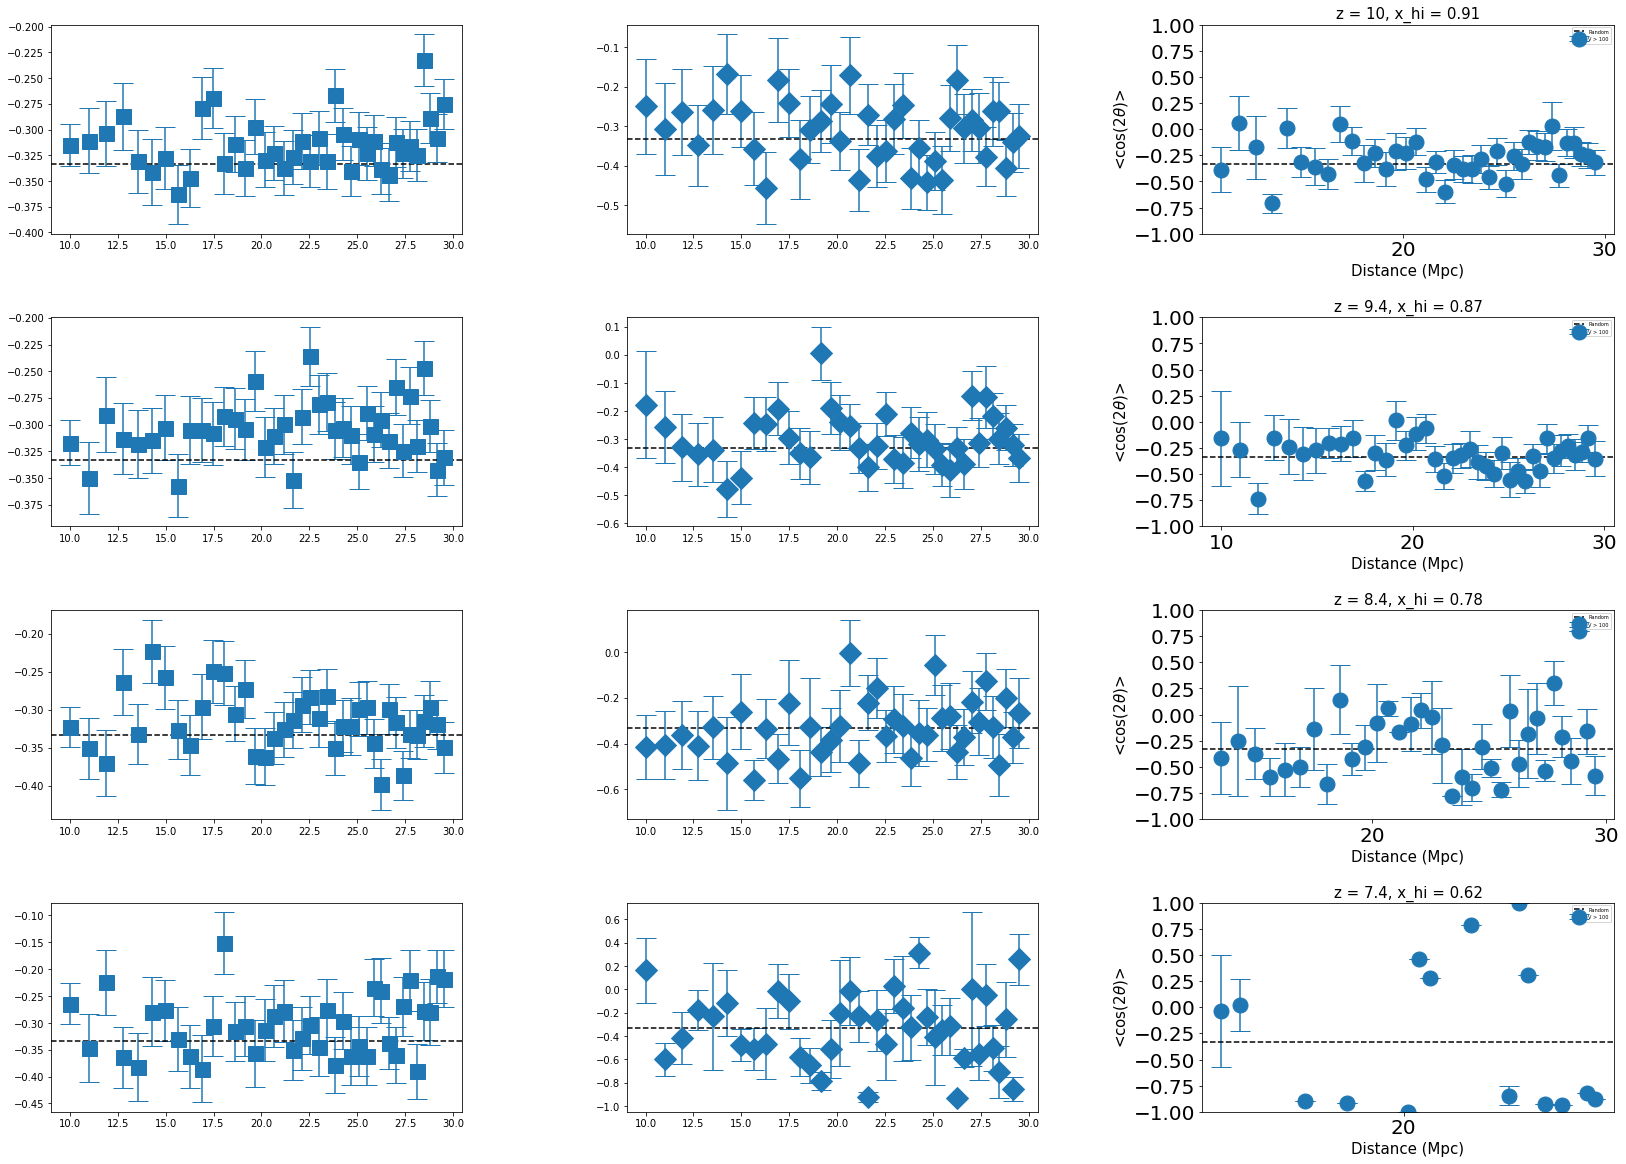

In [44]:
#plot cos(2theta) BIS
#key = np.array([0,15,30,50,75,100])
fig = plt.figure(figsize=(28,20))

labelsize = 15
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
vol_th = [10,50,100]
marker = [u's', u'D', u'o']

for ii in range(nfiles):
    name = inprefix[ii]
    n_cross = np.zeros(len(key)-1)
    curr = list(zip(*params[ii]))
    for jj in range(len(vol_th)):
        ax = plt.subplot(nfiles, len(vol_th), ii*len(vol_th) +jj+1)
        mean_z = []
        err_z = []
        for d in range(len(key)-1):
            sel_id = [i for i in range(len(curr[0])) \
                      if (curr[0][i] <= key[d+1] and curr[0][i] > key[d] and curr[1][i] >= vol_th[jj] and curr[2][i] >= vol_th[jj])]
            sel_z = np.array(curr[3])[sel_id]
            n_cross[d]= len(sel_z)
            mean_z.append(np.nanmean(sel_z))
            err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
            
        mean_z=np.asarray(mean_z)
        err_z = np.asarray(err_z)
        s1mask = np.isfinite(mean_z)
        (_, caps, _) =  ax.errorbar(key[1:][s1mask], mean_z[s1mask], err_z[s1mask], fmt='o', markersize=15, linestyle ="None", \
                    label='V > '+str(vol_th[jj]), marker = marker[jj],capsize = 10)
        for cap in caps:
            cap.set_markeredgewidth(1)
       # for i, txt in enumerate(n_cross):
        #    ax.annotate(txt, (key[i+1]+1, mean_z[i]))   
        ax.axhline(y=-0.333, xmin=0, xmax=100, c='k',linestyle = '--',label='Random') 

    #ax.errorbar(key[1:], np.mean(bootstrap_mean, axis = 0), np.std(bootstrap_mean, axis = 0)/10, fmt='o', 
    #            markersize=15, linestyle ="None", label='Average (bootstrapping ,n = 10)')  
        ax.set_title(mylegend[ii], fontsize=labelsize)
        ax.set_xlabel("Distance (Mpc)", fontsize=labelsize)
        ax.set_ylabel(r'<cos(2$\theta$)>', fontsize=labelsize)
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylim((-1,1))
        ax.legend(fontsize=5 )


/home/simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


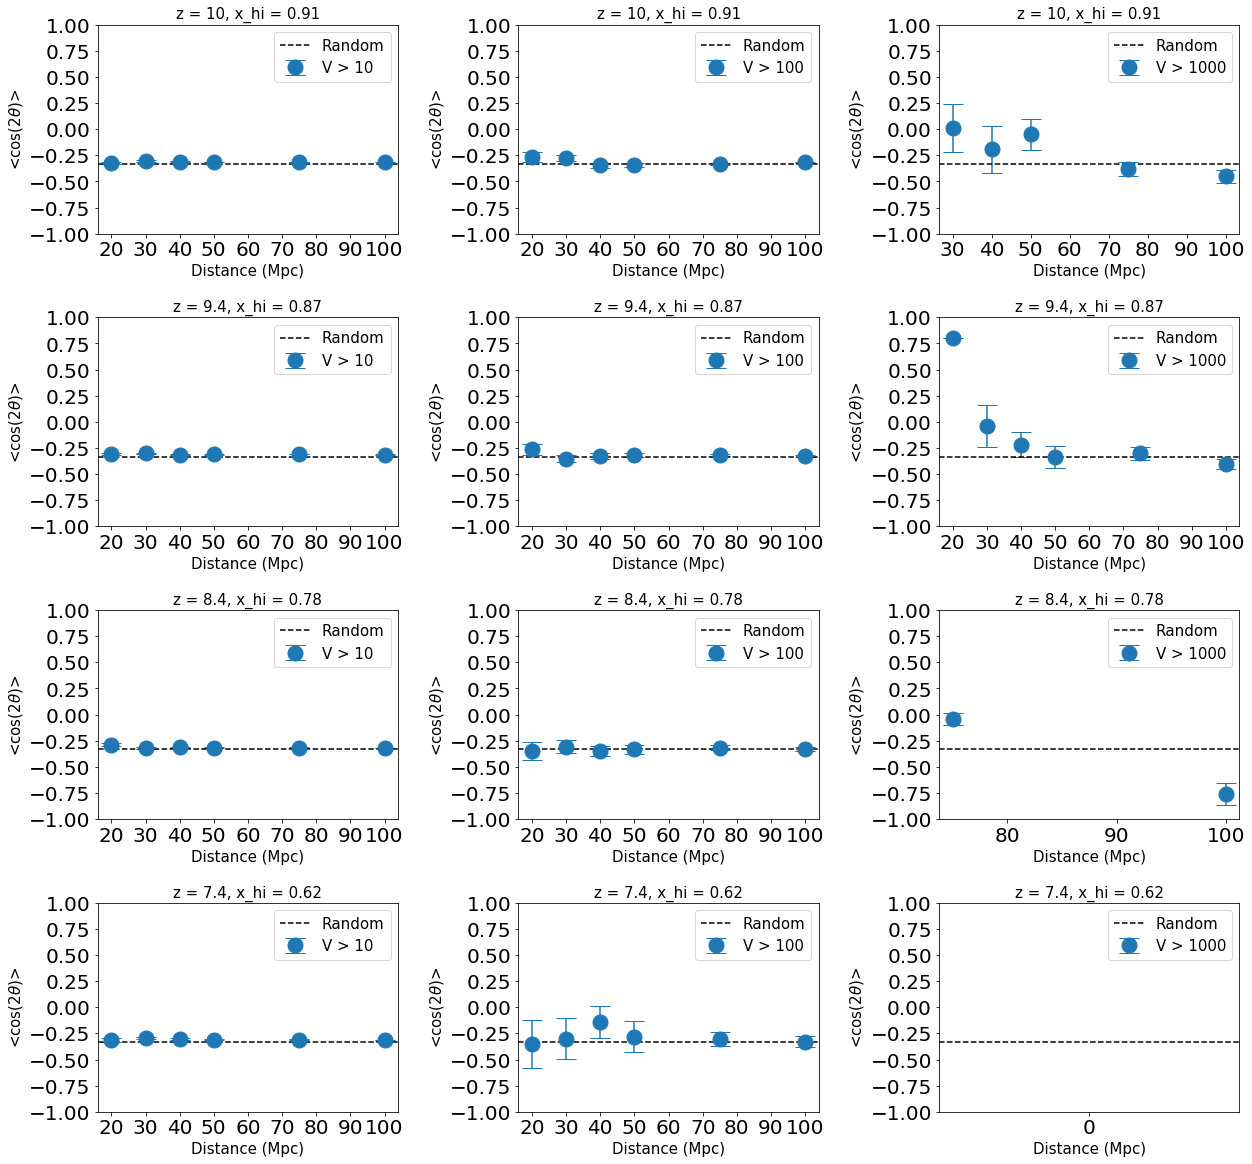

In [6]:
#plot cos(2theta) INTERVAL
fig = plt.figure(figsize=(28,20))

labelsize = 15
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
vol_th = [10,100,1000,float("inf")]
marker = [u's', u'D', u'o']
key = [10,20,30,40,50,75,100,150]
key = np.asarray(key)
for ii in range(nfiles):
    name = inprefix[ii]
    n_cross = np.zeros(len(key)-1)
    curr = list(zip(*params[ii]))
    for jj in range(len(vol_th)-1):
        ax = plt.subplot(nfiles, len(vol_th), ii*len(vol_th) +jj+1)
        mean_z = []
        err_z = []
        for d in range(len(key)-1):
            sel_id = [i for i in range(len(curr[0])) \
                      if (curr[0][i] <= key[d+1] and curr[0][i] > key[d]\
                          and curr[1][i] >= vol_th[jj] and curr[1][i] < vol_th[jj+1] \
                          and curr[2][i] >= vol_th[jj] and curr[2][i] < vol_th[jj+1])]
            sel_z = np.array(curr[3])[sel_id]
            n_cross[d]= len(sel_z)
            mean_z.append(np.nanmean(sel_z))
            err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
            
        mean_z=np.asarray(mean_z)
        err_z = np.asarray(err_z)
        s1mask = np.isfinite(mean_z)
        (_, caps, _) =  ax.errorbar(key[1:][s1mask], mean_z[s1mask], err_z[s1mask], fmt='o', markersize=15, linestyle ="None", \
                    label='V > '+str(vol_th[jj]),capsize = 10)
        for cap in caps:
            cap.set_markeredgewidth(1)
       # for i, txt in enumerate(n_cross):
        #    ax.annotate(txt, (key[i+1]+1, mean_z[i]))   
        ax.axhline(y=-0.333, xmin=0, xmax=100, c='k',linestyle = '--',label='Random') 

    #ax.errorbar(key[1:], np.mean(bootstrap_mean, axis = 0), np.std(bootstrap_mean, axis = 0)/10, fmt='o', 
    #            markersize=15, linestyle ="None", label='Average (bootstrapping ,n = 10)')  
        ax.set_title(mylegend[ii], fontsize=labelsize)
        ax.set_xlabel("Distance (Mpc)", fontsize=labelsize)
        ax.set_ylabel(r'<cos(2$\theta$)>', fontsize=labelsize)
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylim((-1,1))
        ax.legend(fontsize=15 )


In [224]:
#Bootstrapping 
vol_th = [10,50,100]
#temp=[[[]for i in range(25)]for j in range(4)]
temp= [[]for i in range(25)]
for ii in range(1):
    name = inprefix[ii]
    curr_n = int(nbubbles[ii])
    cent_arr = bub_cent[ii]
    vol_arr = bub_vol[ii]
    vec_arr1 = bub_vec1[ii]
    vec_arr2 = bub_vec2[ii]
    vec_arr3 = bub_vec3[ii]
    svec_arr3 = list(vec_arr3)
    for k in range(0, 25):
        shuffle(svec_arr3)
        for j in range(0, curr_n):
            for l in range(j+1, curr_n):
                centerA = np.asarray(cent_arr[j])
                centerB = np.asarray(cent_arr[l])
                dist    = np.linalg.norm(centerA-centerB)
                volA  = vol_arr[j] 
                volB  = vol_arr[l]   
                if(dist <= 100 and volA >= min(vol_th) and volB >= min(vol_th)):
                    cos2t = 2*np.dot(svec_arr3[j], svec_arr3[l])**2-1
                    temp[k].append([dist, volA, volB, cos2t])
       

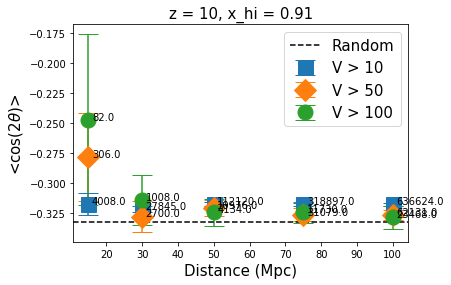

In [227]:
#plot cos(2theta)

key = np.array([0,15,30,50,75,100])
labelsize = 15
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
vol_th = [10,50,100]
marker = [u's', u'D', u'o']

for ii in range(1): 
    name = inprefix[ii]
    ax = plt.subplot(1, 1, ii+1)
    n_cross = np.zeros(len(key)-1)
    curr = list(zip(*params[ii]))
    for jj in range(len(vol_th)):
        mean_z = []
        err_z = []
        bootstrap_mean = [[] for i in range(len(key)-1)]

        for d in range(len(key)-1):
            sel_id = [i for i in range(len(curr[0])) \
                      if (curr[0][i] <= key[d+1] and curr[1][i] >= vol_th[jj] and curr[2][i] >= vol_th[jj])]
            sel_z = np.array(curr[3])[sel_id]
            n_cross[d]= len(sel_z)
            if len(sel_z)>0:
                mean_z.append(np.mean(sel_z))
                #err_z.append(np.std(sel_z)/np.sqrt(len(sel_z)))
            else:
                mean_z.append(0)
                #err_z.append(0)
            for k in range(0,25):
                curr_temp = temp[k]
                currb = list(zip(*curr_temp))
                sel_id = [i for i in range(len(currb[0])) \
                      if (currb[0][i] <= key[d+1] and currb[1][i] >= vol_th[jj] and currb[2][i] >= vol_th[jj])]
                sel_z = np.array(currb[3])[sel_id]
                bootstrap_mean[d].append(np.mean(sel_z))
         
        err_z = np.std(bootstrap_mean, axis = 1)
        (_, caps, _) =  ax.errorbar(key[1:], mean_z, err_z, fmt='o', markersize=15, linestyle ="None", \
                    label='V > '+str(vol_th[jj]), marker = marker[jj],capsize = 10)
        for cap in caps:
            cap.set_markeredgewidth(1)
        for i, txt in enumerate(n_cross):
            ax.annotate(txt, (key[i+1]+1, mean_z[i]))   
    #ax.errorbar(key[1:], np.mean(bootstrap_mean, axis = 0), np.std(bootstrap_mean, axis = 0)/10, fmt='o', 
    #            markersize=15, linestyle ="None", label='Average (bootstrapping ,n = 10)')  
    ax.set_title(mylegend[ii], fontsize=labelsize)
    ax.set_xlabel("Distance (Mpc)", fontsize=labelsize)
    ax.set_ylabel(r'<cos(2$\theta$)>', fontsize=labelsize)
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.axhline(y=-0.333, xmin=0, xmax=100, c='k',linestyle = '--',label='Random') 
    ax.legend(fontsize=15 )

In [130]:
x, y, z = zip(*select_cent)
u, v, w = zip(*select_eig)
x = np.asarray(x).astype(float)
y = np.asarray(y).astype(float)
z = np.asarray(z).astype(float)
sel_id = [i for i in range(len(x)) \
                      if ( (i > 202 and i< 230))]

ipv.figure()
quiver = ipv.quiver(x[sel_id], y[sel_id], z[sel_id], np.array(u)[sel_id], np.array(v)[sel_id], np.array(w)[sel_id], size=7, size_selected=10)
ipv.xyzlim(0, 200)
ipv.show()


VkJveChjaGlsZHJlbj0oRmlndXJlKGNhbWVyYT1QZXJzcGVjdGl2ZUNhbWVyYShmb3Y9NDYuMCwgcG9zaXRpb249KDAuMCwgMC4wLCAyLjApLCBxdWF0ZXJuaW9uPSgwLjAsIDAuMCwgMC4wLCDigKY=


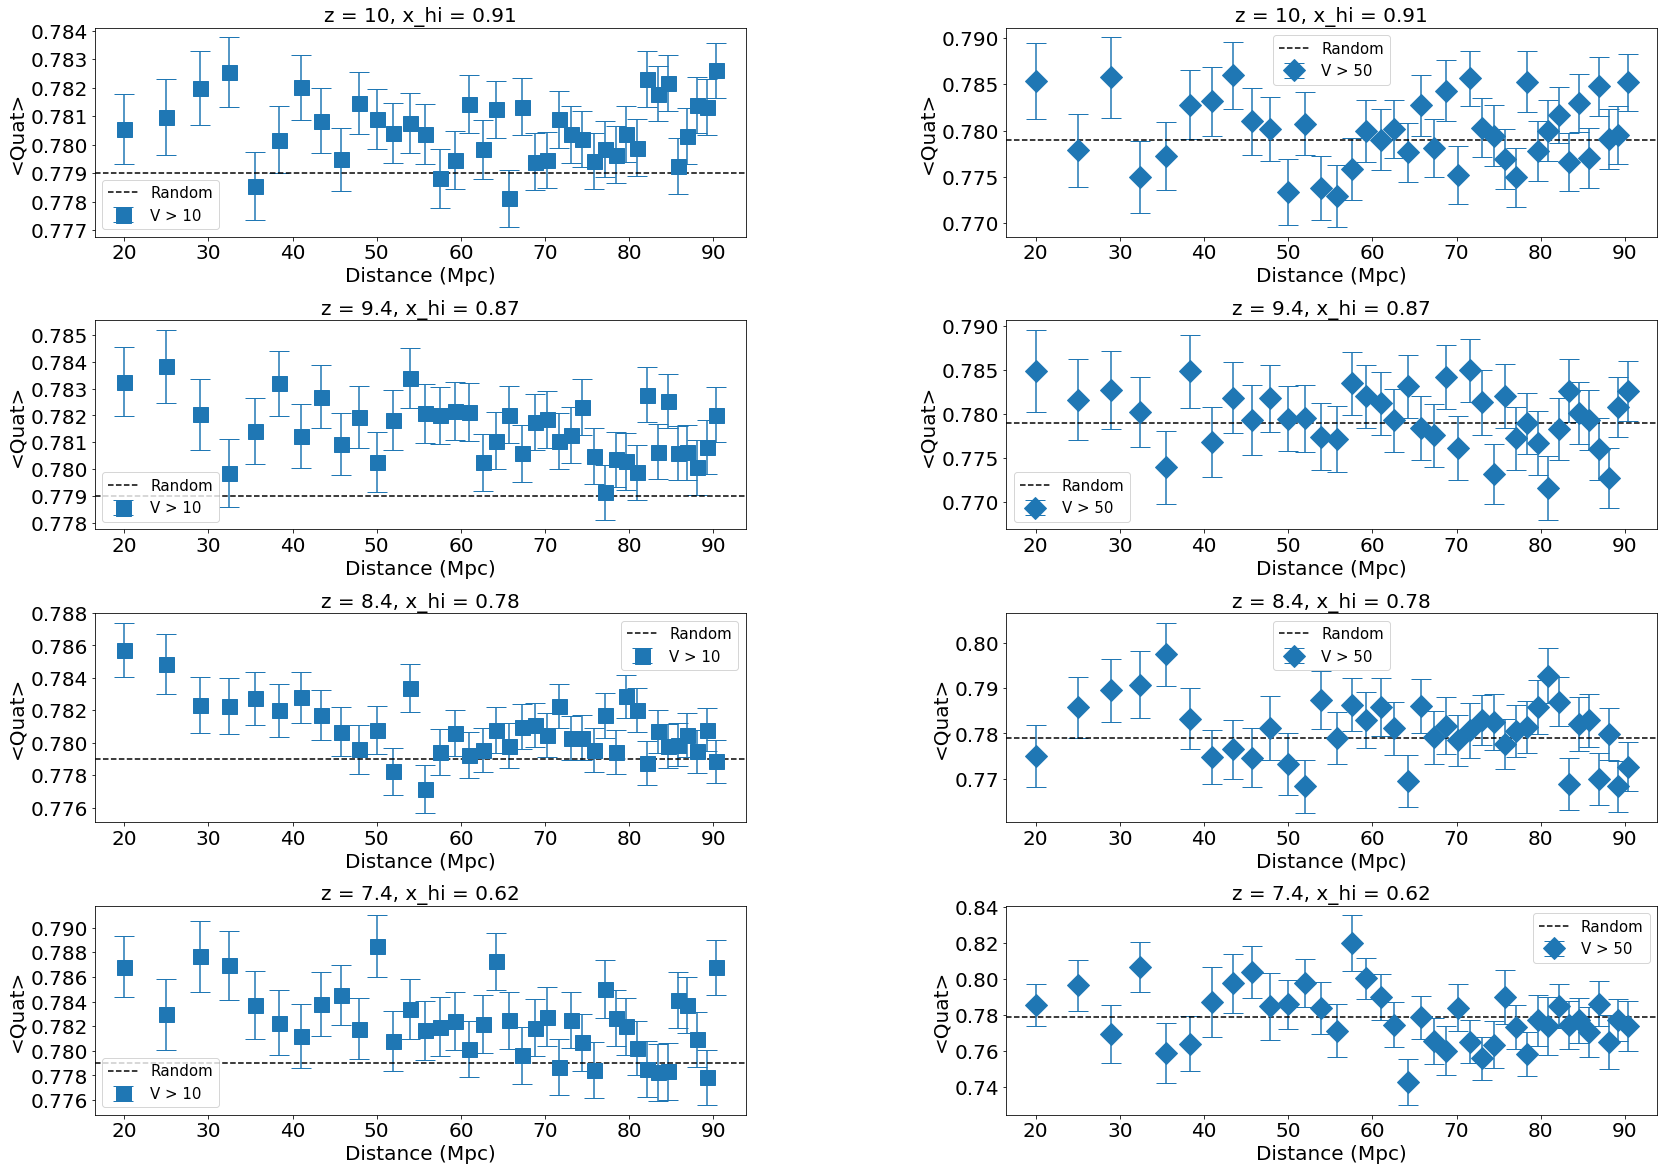

In [9]:
#plot Quat
fig = plt.figure(figsize=(28,20))
labelsize = 20
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
vol_th = [10,50]
marker = [u's', u'D', u'o']

for ii in range(nfiles):
    name = inprefix[ii]
    n_cross = np.zeros(len(key)-1)
    curr = list(zip(*params[ii]))
    for jj in range(len(vol_th)):
        ax = plt.subplot(nfiles, len(vol_th), ii*len(vol_th) +jj+1)
        mean_z = []
        err_z = []
        for d in range(len(key)-1):
            sel_id = [i for i in range(len(curr[0])) \
                      if (curr[0][i] <= key[d+1] and curr[0][i] > key[d] and curr[1][i] >= vol_th[jj] and curr[2][i] >= vol_th[jj])]
            sel_z = np.array(curr[4])[sel_id]
            n_cross[d]= len(sel_z)
            mean_z.append(np.nanmean(sel_z))
            err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
    
        mean_z=np.asarray(mean_z)
        err_z = np.asarray(err_z)
        s1mask = np.isfinite(mean_z)
        (_, caps, _) =  ax.errorbar(key[1:][s1mask], mean_z[s1mask], err_z[s1mask], fmt='o', markersize=15, linestyle ="None", \
                    label='V > '+str(vol_th[jj]), marker = marker[jj],capsize = 10)
        for cap in caps:
            cap.set_markeredgewidth(1)
 
            ax.set_title(mylegend[ii], fontsize=labelsize)
        ax.set_xlabel("Distance (Mpc)", fontsize=labelsize)
        ax.set_ylabel('<Quat>', fontsize=labelsize)
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.axhline(y=0.779, xmin=0, xmax=100, c='k',linestyle = '--',label='Random') 
        ax.legend(fontsize=15 )

In [16]:
# New correlation mmetric
params = [[] for i in range(4)]
for ii in range(0,4): 
    name = inprefix[ii]
    select_id = []
    select_q = []
    select_cent = []
    select_eig = []
    #Test orientation ocsinu
    sel = 0
    
    curr_n = int(nbubbles[ii])
    cent_arr = bub_cent[ii]
    vol_arr = bub_vol[ii]
    vec_arr1 = bub_vec1[ii]
    vec_arr2 = bub_vec2[ii]
    vec_arr3 = bub_vec3[ii]
    mat_arr = bub_mat[ii]
    visited = np.zeros(curr_n)
    for j in range(0, curr_n):
        for l in range(j+1, curr_n):
            centerA = np.asarray(cent_arr[j])
            centerB = np.asarray(cent_arr[l])
            dist    = np.linalg.norm(centerA-centerB)  
            volA  = vol_arr[j] 
            volB  = vol_arr[l]             
            mC = np.matmul(mat_arr[j], mat_arr[l])
            tr = np.trace(mC)
            metric = 1 - tr/(np.linalg.norm(mat_arr[j])*np.linalg.norm(mat_arr[l]))
            params[ii].append([dist, volA, volB, metric])
                       

/home/simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


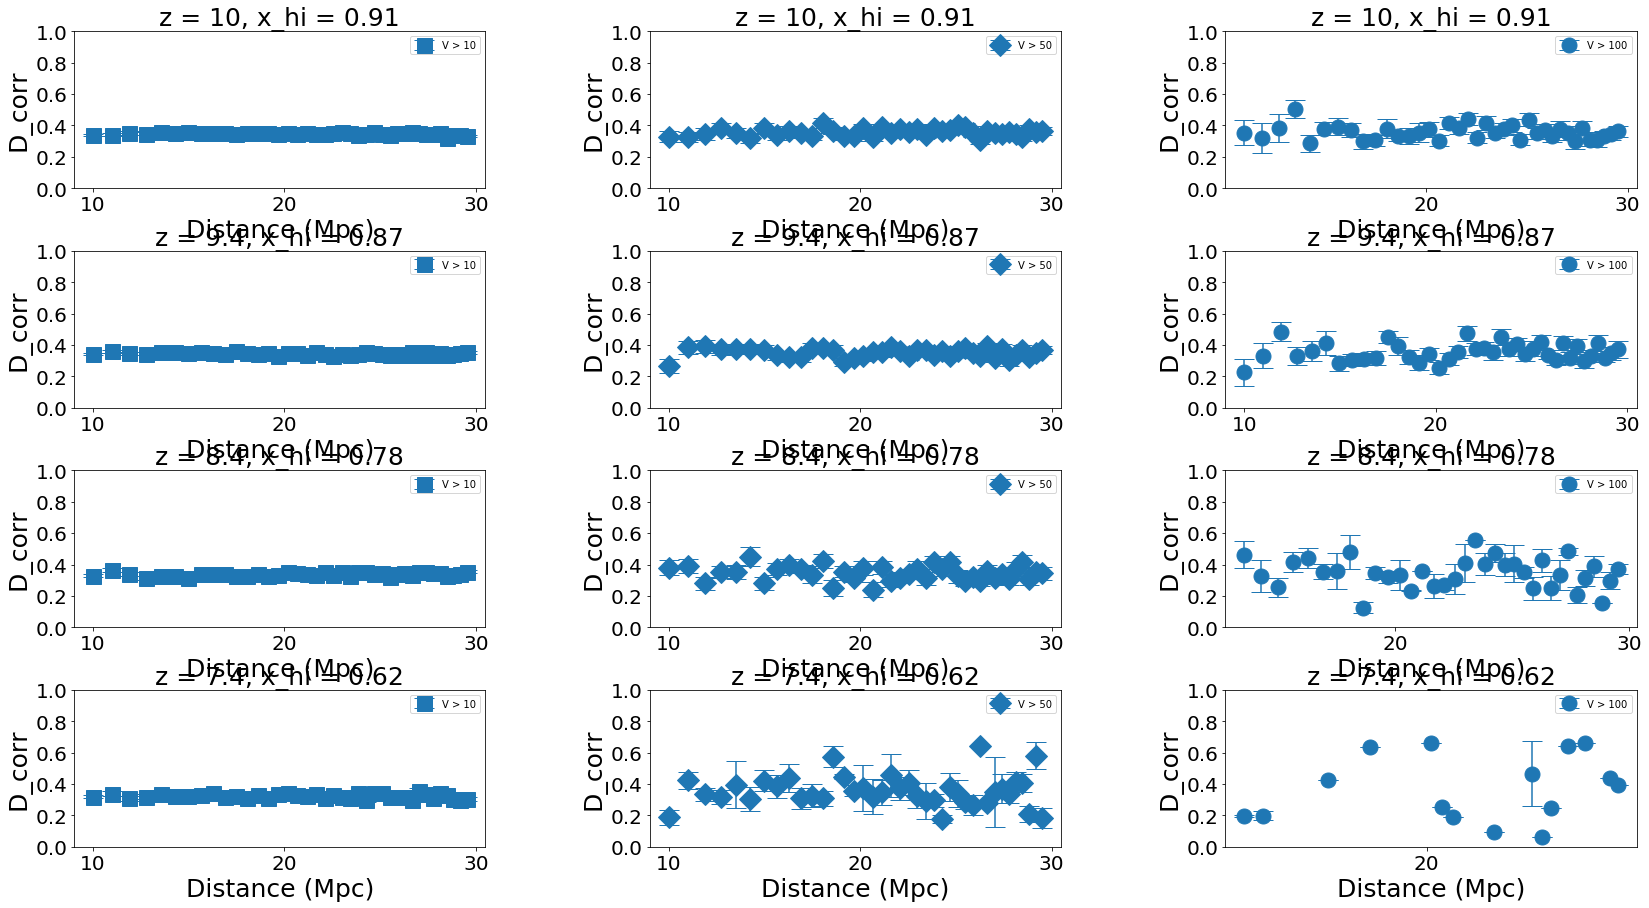

In [41]:
fig = plt.figure(figsize=(28,15))

labelsize = 25
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
vol_th = [10,50,100]
marker = [u's', u'D', u'o']

for ii in range(nfiles):
    name = inprefix[ii]
    n_cross = np.zeros(len(key)-1)
    curr = list(zip(*params[ii]))
    for jj in range(len(vol_th)):
        ax = plt.subplot(nfiles, len(vol_th), ii*len(vol_th) +jj+1)
        mean_z = []
        err_z = []
        for d in range(len(key)-1):
            sel_id = [i for i in range(len(curr[0])) \
                      if (curr[0][i] <= key[d+1] and curr[0][i] > key[d] and curr[1][i] >= vol_th[jj] and curr[2][i] >= vol_th[jj])]
            sel_z = np.array(curr[5])[sel_id]
            n_cross[d]= len(sel_z)
            mean_z.append(np.nanmean(sel_z))
            err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
            
        mean_z=np.asarray(mean_z)
        err_z = np.asarray(err_z)
        s1mask = np.isfinite(mean_z)
        (_, caps, _) =  ax.errorbar(key[1:][s1mask], mean_z[s1mask], err_z[s1mask], fmt='o', markersize=15, linestyle ="None", \
                    label='V > '+str(vol_th[jj]), marker = marker[jj],capsize = 10)
        for cap in caps:
            cap.set_markeredgewidth(1)

        ax.set_title(mylegend[ii], fontsize=labelsize)
        ax.set_xlabel("Distance (Mpc)", fontsize=labelsize)
        ax.set_ylabel(r'D_corr', fontsize=labelsize)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylim((0,1))
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax.legend(fontsize=10 )

In [56]:
# Orientation / closest neighbor
paramsdir = [[] for i in range(4)]

for ii in range(nfiles): 
    name = inprefix[ii]
    sel = 0   
    curr_n = int(nbubbles[ii])
    idx_arr = np.zeros((curr_n, 3, 2))-1
    cent_arr = bub_cent[ii]
    vol_arr = bub_vol[ii]
    vec_arr1 = bub_vec1[ii]
    vec_arr2 = bub_vec2[ii]
    vec_arr3 = bub_vec3[ii]
    for j in range(0, curr_n):
        centerA = np.asarray(cent_arr[j])
        volA  = vol_arr[j] 
        for l in range(j+1, curr_n):
            centerB = np.asarray(cent_arr[l])
            dist    = np.linalg.norm(centerA-centerB)  
            volB    = vol_arr[l] 

            if(volB >= 100 and (idx_arr[j][2][0]==-1 or dist < idx_arr[j][2][1])):
                idx_arr[j][2][0] = l
                idx_arr[j][2][1] = dist
            if(volB >= 50 and (idx_arr[j][1][0]==-1 or dist < idx_arr[j][1][1])):
                idx_arr[j][1][0] = l
                idx_arr[j][1][1] = dist
            if(volB >= 10 and (idx_arr[j][0][0]==-1 or dist < idx_arr[j][0][1])):
                idx_arr[j][0][0] = l
                idx_arr[j][0][1] = dist
            if(volA >= 100 and (idx_arr[l][2][0]==-1 or dist < idx_arr[l][2][1])):
                idx_arr[l][2][0] = j
                idx_arr[l][2][1] = dist
            if(volA >= 50 and (idx_arr[l][1][0]==-1 or dist < idx_arr[l][1][1])):
                idx_arr[l][1][0] = j
                idx_arr[l][1][1] = dist
            if(volA >= 10 and (idx_arr[l][0][0]==-1 or dist < idx_arr[l][0][1])):
                idx_arr[l][0][0] = j
                idx_arr[l][0][1] = dist
                
        centerA = np.asarray(cent_arr[j])
        centerB = np.asarray(cent_arr[int(idx_arr[j][0][0])])
        cos2t10 = 2*np.dot(vec_arr3[j], (centerA-centerB)/idx_arr[j][0][1])**2-1 if idx_arr[j][0][0] != -1 else -2       
        #params10[ii].append([idx_arr[j][0][1], volA, cos2t])

        centerB = np.asarray(cent_arr[int(idx_arr[j][1][0])]) 
        cos2t50 = 2*np.dot(vec_arr3[j], (centerA-centerB)/idx_arr[j][1][1])**2-1 if idx_arr[j][1][0] != -1 else -2 
        #params50[ii].append([idx_arr[j][1][1], volA, cos2t])

        centerB = np.asarray(cent_arr[int(idx_arr[j][2][0])])
        cos2t100 = 2*np.dot(vec_arr3[j], (centerA-centerB)/idx_arr[j][2][1])**2-1 if idx_arr[j][2][0] != -1 else -2
        #params100[ii].append([idx_arr[j][2][1], volA, cos2t])
        paramsdir[ii].append([idx_arr[j][0][1], idx_arr[j][1][1], idx_arr[j][2][1], volA, volB, cos2t10, cos2t50, cos2t100])


In [45]:

print idx_arr[9][2][:]
print curr_n

[1574.           11.62092509]
1913


In [14]:
# Orientation / closest neighbor bis
params10 = [[] for i in range(4)]
params50 = [[] for i in range(4)]
params100 = [[] for i in range(4)]

for ii in range(0,4): 
    name = inprefix[ii]
    select_id = []
    select_q = []
    select_cent = []
    select_eig = []
    #Test orientation ocsinu
    sel = 0
    
    curr_n = int(nbubbles[ii])
    idx_arr = np.zeros((curr_n, 3, 2))-1
    cent_arr = bub_cent[ii]
    vol_arr = bub_vol[ii]
    vec_arr1 = bub_vec1[ii]
    vec_arr2 = bub_vec2[ii]
    vec_arr3 = bub_vec3[ii]
    for j in range(0, curr_n):
        centerA = np.asarray(cent_arr[j])
        volA  = vol_arr[j] 
        for l in range(j+1, curr_n):
            centerB = np.asarray(cent_arr[l])
            dist    = np.linalg.norm(centerA-centerB)  
            volB    = vol_arr[l]             
            if(volB >= 100 and (idx_arr[j][2][0]==-1 or dist < idx_arr[j][2][1])):
                idx_arr[j][2][0] = l
                idx_arr[j][2][1] = dist
            if(volB >= 50 and (idx_arr[j][1][0]==-1 or dist < idx_arr[j][1][1])):
                idx_arr[j][1][0] = l
                idx_arr[j][1][1] = dist
            if(volB >= 10 and (idx_arr[j][0][0]==-1 or dist < idx_arr[j][0][1])):
                idx_arr[j][0][0] = l
                idx_arr[j][0][1] = dist
            if(volA >= 100 and (idx_arr[l][2][0]==-1 or dist < idx_arr[l][2][1])):
                idx_arr[l][2][0] = j
                idx_arr[l][2][1] = dist
            if(volA >= 50 and (idx_arr[l][1][0]==-1 or dist < idx_arr[l][1][1])):
                idx_arr[l][1][0] = j
                idx_arr[l][1][1] = dist
            if(volA >= 10 and (idx_arr[l][0][0]==-1 or dist < idx_arr[l][0][1])):
                idx_arr[l][0][0] = j
                idx_arr[l][0][1] = dist
                
        centerA = np.asarray(cent_arr[j])
        centerB = np.asarray(cent_arr[int(idx_arr[j][0][0])])
        cos2t = 2*np.dot(vec_arr3[j], (centerA-centerB)/idx_arr[j][0][1])**2-1 if idx_arr[j][0][0] != -1 else -2       
        params10[ii].append([idx_arr[j][0][1], volA, cos2t])

        centerB = np.asarray(cent_arr[int(idx_arr[j][1][0])]) 
        cos2t = 2*np.dot(vec_arr3[j], (centerA-centerB)/idx_arr[j][1][1])**2-1 if idx_arr[j][1][0] != -1 else -2 
        params50[ii].append([idx_arr[j][1][1], volA, cos2t])

        centerB = np.asarray(cent_arr[int(idx_arr[j][2][0])])
        cos2t = 2*np.dot(vec_arr3[j], (centerA-centerB)/idx_arr[j][2][1])**2-1 if idx_arr[j][2][0] != -1 else -2
        params100[ii].append([idx_arr[j][2][1], volA, cos2t])
    

In [52]:
vol_th = [10,50,100]
key1 = np.zeros(20)
key1[0]=0
key1[1]=6

for i in range(2,20):
    key1[i] = key1[i-1] + 5/key1[i-1]

key2 = np.zeros(20)
key2[0]=0
key2[1]=10

for i in range(2,20):
    key2[i] = key2[i-1] + 10/key2[i-1]
    
print key1
print key2

for ii in range(1): 
    name = inprefix[ii]
    n_cross = np.zeros([len(vol_th),len(key1)-1])
    curr = list(zip(*paramsdir[ii]))
    for jj in range(len(vol_th)):
        mean_z = []
        err_z = []
        key = key1 if jj == 0 else key2
        for d in range(len(key)-1):
            sel_id = [i for i in range(len(curr[0+jj])) \
                      if (curr[0+jj][i] <= key[d+1] and curr[0+jj][i] > key[d] and curr[3][i] >= vol_th[jj] and curr[4][i] >= vol_th[jj] and curr[5+jj][i] > -2)]
            sel_z = np.array(curr[5+jj])[sel_id]
            n_cross[jj][d]= len(sel_z)
    print n_cross

[ 0.          6.          6.83333333  7.56504065  8.22597563  8.83380627
  9.3998137   9.93173914 10.43517564 10.91432426 11.37243782 11.81209729
 12.23539215 12.64404272 13.03948586 13.42293656 13.7954333  14.15787207
 14.51103249 14.85559791]
[ 0.         10.         11.         11.90909091 12.74878557 13.533174
 14.27209896 14.97276675 15.64064598 16.28000576 16.89425616 17.48617331
 18.05805372 18.61182326 19.14911613 19.67133345 20.17968739 20.67523521
 21.15890564 21.63151988]
[[117. 163. 154. 167. 172. 168. 158. 133. 110.  89.  73.  55.  62.  46.
   52.  23.  23.  17.  27.]
 [ 51.  49.  48.  47.  39.  40.  42.  29.  37.  28.  43.  22.  28.  17.
    8.  11.  12.   6.  10.]
 [  0.  12.  10.  10.  13.  22.  17.  19.  27.  14.  26.  18.  25.  12.
   11.   6.  12.  11.  17.]]


/home/simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


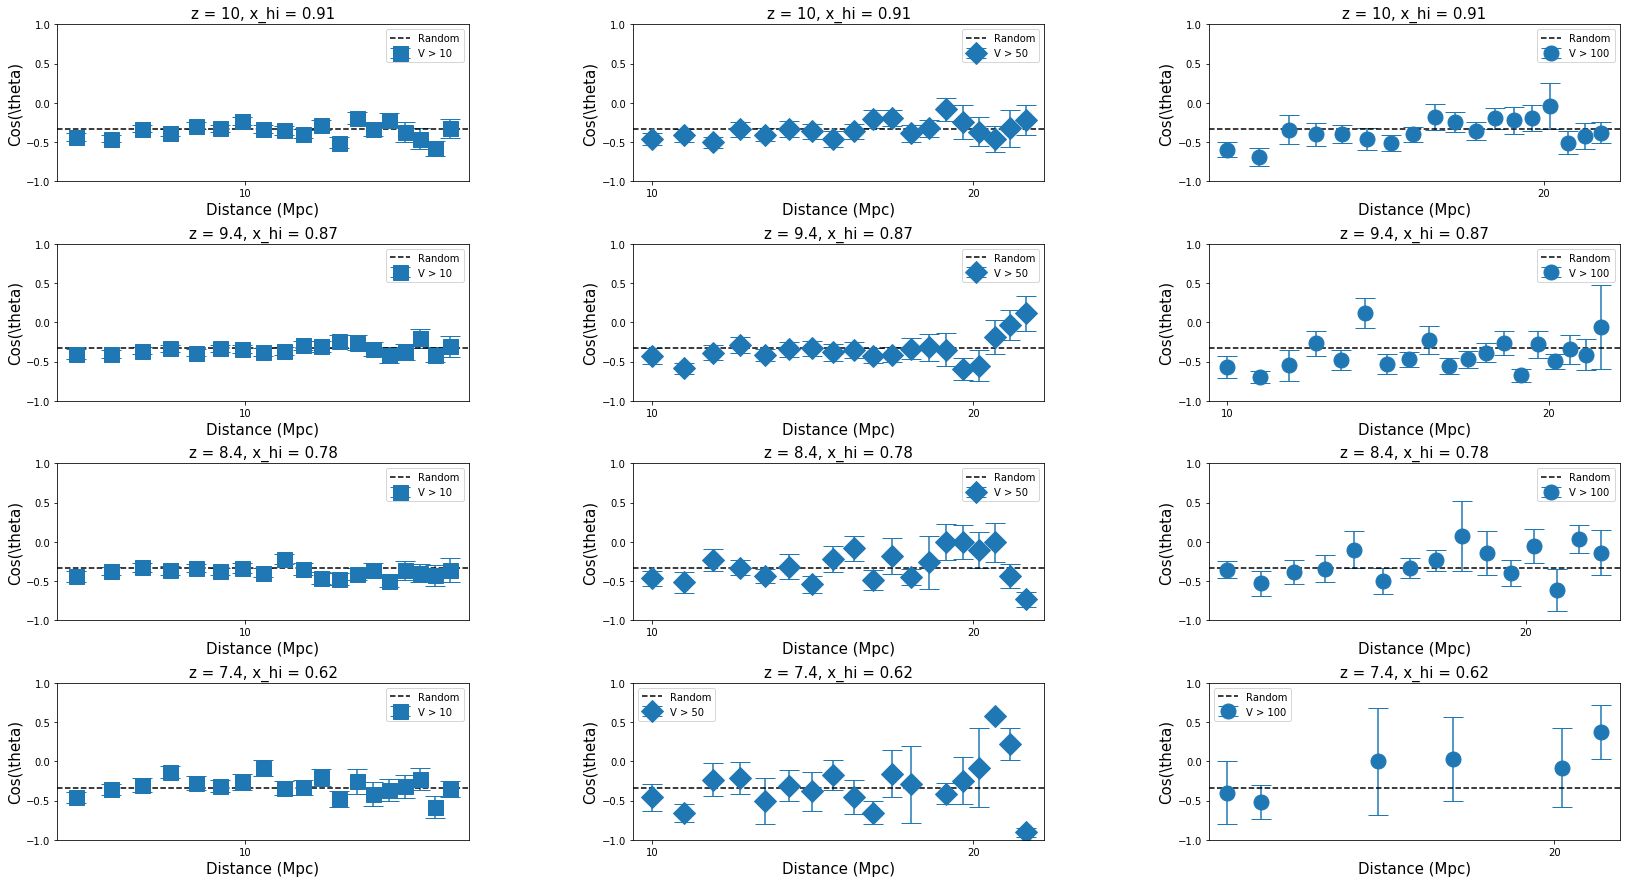

In [58]:
fig = plt.figure(figsize=(28,15))
labelsize = 15
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
vol_th = [10,50,100]
marker = [u's', u'D', u'o']

for ii in range(nfiles):
    name = inprefix[ii]
    n_cross = np.zeros(len(key)-1)
    curr = list(zip(*paramsdir[ii]))
    for jj in range(len(vol_th)):
        ax = plt.subplot(nfiles, len(vol_th), ii*len(vol_th) +jj+1)
        mean_z = []
        err_z = []
        key = key1 if jj == 0 else key2

        for d in range(len(key)-1):
            sel_id = [i for i in range(len(curr[0+jj])) \
                      if (curr[0+jj][i] <= key[d+1] and curr[0+jj][i] > key[d] and curr[3][i] >= vol_th[jj] and curr[4][i] >= vol_th[jj] and curr[5+jj][i] > -2)]
            sel_z = np.array(curr[5+jj])[sel_id]
            mean_z.append(np.nanmean(sel_z))
            err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
            
        mean_z=np.asarray(mean_z)
        err_z = np.asarray(err_z)
        s1mask = np.isfinite(mean_z)
        (_, caps, _) =  ax.errorbar(key[1:][s1mask], mean_z[s1mask], err_z[s1mask], fmt='o', markersize=15, linestyle ="None", \
                    label='V > '+str(vol_th[jj]), marker = marker[jj],capsize = 10)
        for cap in caps:
            cap.set_markeredgewidth(1)
        ax.axhline(y=-0.333, xmin=0, xmax=100, c='k',linestyle = '--',label='Random') 
       # for i, txt in enumerate(n_cross):
          #  ax.annotate(txt, (key[i+1]+1, mean_z[i]))   
    #ax.errorbar(key[1:], np.mean(bootstrap_mean, axis = 0), np.std(bootstrap_mean, axis = 0)/10, fmt='o', 
    #            markersize=15, linestyle ="None", label='Average (bootstrapping ,n = 10)')  
        ax.set_title(mylegend[ii], fontsize=labelsize)
        ax.set_xlabel("Distance (Mpc)", fontsize=labelsize)
        ax.set_ylabel(r'Cos(\theta)', fontsize=labelsize)
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        plt.ylim((-1,1))
        ax.legend(fontsize=10 )

In [3]:
#Random Distribution

fig = plt.figure(figsize=(28,20))
plt.subplots_adjust(hspace=0.4,wspace = 0.4)

key = np.array([0,10,20,30,50,75,100,125,150])
bins = [(key[i]+key[i+1])/2 for i in range(0, len(key)-1)]
start_j = 2
curve = ['Simulated 21cmFast', 'Random selection in 21cmFast', 'Half simu, half uniform random', "Full uniform random"]
for ii, name in enumerate(inprefix): 

    ax = plt.subplot(3, 2, ii+1)

    count = np.zeros((len(key)-1))
    var = []
    for i in range(0,array[0]):
        with open('DCT_Final_VF/out/'+name+str(myarray[i])+'.txt') as f:
            var.append(json.load(f))

    vec= []
    nbubbles  = 0
    
    for p in range(start_j, array[0]):
        for k in range(0,len(var[p])):
            nbubbles += 1
            vec.append(var[p][k])
            
    params = []   
    for j in range(0, nbubbles):
        for l in range(j+1, nbubbles):
            centerA = np.asarray(vec[j]["center"])
            centerB = np.asarray(vec[l]["center"])
            dist     = np.linalg.norm(centerA-centerB)                        
            if dist <= 150:
                mA = np.column_stack((vec[j]["eigenvec_3"],
                                vec[j]["eigenvec_2"],
                                vec[j]["eigenvec_1"]))
                if np.linalg.det(mA) < 0:
                    mA[:,2] *=-1
                mB = np.column_stack((vec[l]["eigenvec_3"],
                                    vec[l]["eigenvec_2"],
                                    vec[l]["eigenvec_1"]))
                if np.linalg.det(mB) < 0:
                    mB[:,2] *=-1   
                id = int(uniform(0,nbubbles)) 
                mC = np.column_stack((vec[id]["eigenvec_3"],
                                    vec[id]["eigenvec_2"],
                                    vec[id]["eigenvec_1"]))
                if np.linalg.det(mC) < 0:
                    mC[:,2] *=-1   
                qA = Quaternion(matrix=mA)
                qB = Quaternion(matrix=mB)
                qC = Quaternion(matrix=mC)
                qD = Quaternion.random()
                qE = Quaternion.random()
                maxAB = -1
                maxAC = -1
                maxAD = -1
                maxDE = -1
                for jj in range(0,4):
                    maxAB = max(maxAB,best_angle(jj,qA,qB))
                    maxAC = max(maxAC,best_angle(jj,qA,qC))
                    maxAD = max(maxAD,best_angle(jj,qA,qD))
                    maxDE = max(maxDE, best_angle(jj, qD, qE))
                #q_dist = (qB.inverse*qA).real
                #q_dist_rand = (qC.inverse*qA).real
                #params.append([dist, np.cos(2*q_dist), np.cos(2*q_dist_rand)])       
                params.append([dist, maxAB, maxAC, maxAD, maxDE])       
    mean_quat_d = []
    err_quat_d = []
    rand_quat_d = []
    err_rand_quat_d = []
    rand_quat_d2 = []
    err_rand_quat_d2 = []
    rand_quat_d3 = []
    err_rand_quat_d3 = []
    params = list(zip(*params))
    for d in range(len(key)-1):
        sel_quat_d = [params[1][i] for i in range(len(params[0])) if (params[0][i] <= key[d+1])]
        mean_quat_d.append(np.mean(sel_quat_d))  
        err_quat_d.append(np.std(sel_quat_d)/np.sqrt(len(sel_quat_d)))
        sel_quat_d = [params[2][i] for i in range(len(params[0])) if (params[0][i] <= key[d+1])]
        rand_quat_d.append(np.mean(sel_quat_d))
        err_rand_quat_d.append(np.std(sel_quat_d)/np.sqrt(len(sel_quat_d)))
        sel_quat_d = [params[3][i] for i in range(len(params[0])) if (params[0][i] <= key[d+1])]
        rand_quat_d2.append(np.mean(sel_quat_d))
        err_rand_quat_d2.append(np.std(sel_quat_d)/np.sqrt(len(sel_quat_d)))
        sel_quat_d = [params[4][i] for i in range(len(params[0])) if (params[0][i] <= key[d+1])]
        rand_quat_d3.append(np.mean(sel_quat_d))
        err_rand_quat_d3.append(np.std(sel_quat_d)/np.sqrt(len(sel_quat_d)))
        count[d] = len(sel_quat_d)
    ax.errorbar(keys[1:], mean_quat_d, err_quat_d, fmt='o', markersize=15, linestyle ="None")
    for i, txt in enumerate(count):
        ax.annotate(txt, (key[i+1], mean_quat_d[i]+0.005))
    ax.errorbar(keys[1:], rand_quat_d, err_rand_quat_d, fmt='o', markersize=15, linestyle ="None")
    ax.errorbar(keys[1:], rand_quat_d2, err_rand_quat_d2, fmt='o', markersize=15, linestyle ="None")
    ax.errorbar(keys[1:], rand_quat_d3, err_rand_quat_d3, fmt='o', markersize=15, linestyle ="None")
    ax.set_title(mylegend[ii], fontsize=labelsize)
    ax.set_xlabel("Distance (Mpc)", fontsize=labelsize)
    ax.set_ylabel('Similarity measure', fontsize=labelsize)

    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    #ax.legend(curve)
ax = plt.subplot(3,2,5)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.plot(0, 0, markersize=15, marker='o')
plt.plot(0, 0, markersize=15, marker='o')
plt.plot(0, 0, markersize=15, marker='o')
plt.plot(0, 0, markersize=15, marker='o')
ax.legend(labels = curve, loc = 'upper right', fontsize=25 )

NameError: name 'inprefix' is not defined

<Figure size 2016x1440 with 0 Axes>

In [ ]:
#Old
fig = plt.figure(figsize=(28,20))
plt.subplots_adjust(hspace=0.4,wspace = 0.4)

key = np.array([0,10,20,30,50,75,100,125,150])
bins = [(key[i]+key[i+1])/2 for i in range(0, len(key)-1)]
start_j = 2
curve = ['Simulated 21cmFast', 'Random selection in 21cmFast', 'Half simu, half uniform random', "Full uniform random"]
for ii in range(1): 

    ax = plt.subplot(3, 2, ii+1)
    name = inprefix[ii]
    count = np.zeros((len(key)-1))
    var = []
    for i in range(0,array[0]):
        with open('DCT_Final_VF/out/'+name+str(myarray[i])+'.txt') as f:
            var.append(json.load(f))

    vec= []
    nbubbles  = 0
    
    for p in range(start_j, array[0]):
        for k in range(0,len(var[p])):
            nbubbles += 1
            vec.append(var[p][k])
            
    params = []   
    for j in range(0, nbubbles):
        for l in range(j+1, nbubbles):
            centerA = np.asarray(vec[j]["center"])
            centerB = np.asarray(vec[l]["center"])
            dist     = np.linalg.norm(centerA-centerB)                        
            if dist <= 100:
                mA = np.column_stack((vec[j]["eigenvec_3"],
                                vec[j]["eigenvec_2"],
                                vec[j]["eigenvec_1"]))
                if np.linalg.det(mA) < 0:
                    mA[:,2] *=-1
                mB = np.column_stack((vec[l]["eigenvec_3"],
                                    vec[l]["eigenvec_2"],
                                    vec[l]["eigenvec_1"]))
                if np.linalg.det(mB) < 0:
                    mB[:,2] *=-1   
                id = int(uniform(0,nbubbles)) 
                mC = np.column_stack((vec[id]["eigenvec_3"],
                                    vec[id]["eigenvec_2"],
                                    vec[id]["eigenvec_1"]))
                if np.linalg.det(mC) < 0:
                    mC[:,2] *=-1   
                qA = Quaternion(matrix=mA)
                qB = Quaternion(matrix=mB)
                qC = Quaternion(matrix=mC)
                qD = Quaternion.random()
                qE = Quaternion.random()
                maxAB = -1
                maxAC = -1
                maxAD = -1
                maxDE = -1
                for jj in range(0,4):
                    maxAB = max(maxAB,best_angle(jj,qA,qB))
                    maxAC = max(maxAC,best_angle(jj,qA,qC))
                    maxAD = max(maxAD,best_angle(jj,qA,qD))
                    maxDE = max(maxDE, best_angle(jj, qD, qE))
                #q_dist = (qB.inverse*qA).real
                #q_dist_rand = (qC.inverse*qA).real
                #params.append([dist, np.cos(2*q_dist), np.cos(2*q_dist_rand)])       
                params.append([dist, maxAB, maxAC, maxAD, maxDE])       
    mean_quat_d = []
    err_quat_d = []
    rand_quat_d = []
    err_rand_quat_d = []
    rand_quat_d2 = []
    err_rand_quat_d2 = []
    rand_quat_d3 = []
    err_rand_quat_d3 = []
    params = list(zip(*params))
    for d in range(len(key)-1):
        sel_quat_d = [params[1][i] for i in range(len(params[0])) if (params[0][i] <= key[d+1])]
        mean_quat_d.append(np.mean(sel_quat_d))  
        err_quat_d.append(np.std(sel_quat_d)/np.sqrt(len(sel_quat_d)))
        sel_quat_d = [params[2][i] for i in range(len(params[0])) if (params[0][i] <= key[d+1])]
        rand_quat_d.append(np.mean(sel_quat_d))
        err_rand_quat_d.append(np.std(sel_quat_d)/np.sqrt(len(sel_quat_d)))
        sel_quat_d = [params[3][i] for i in range(len(params[0])) if (params[0][i] <= key[d+1])]
        rand_quat_d2.append(np.mean(sel_quat_d))
        err_rand_quat_d2.append(np.std(sel_quat_d)/np.sqrt(len(sel_quat_d)))
        sel_quat_d = [params[4][i] for i in range(len(params[0])) if (params[0][i] <= key[d+1])]
        rand_quat_d3.append(np.mean(sel_quat_d))
        err_rand_quat_d3.append(np.std(sel_quat_d)/np.sqrt(len(sel_quat_d)))
        count[d] = len(sel_quat_d)
    ax.errorbar(bins, mean_quat_d, err_quat_d, fmt='o', markersize=15, linestyle ="None")
    for i, txt in enumerate(count):
        ax.annotate(txt, (key[i+1], mean_quat_d[i]+0.005))
    ax.errorbar(bins, rand_quat_d, err_rand_quat_d, fmt='o', markersize=15, linestyle ="None")
    #ax.errorbar(bins, rand_quat_d2, err_rand_quat_d2, fmt='o', markersize=15, linestyle ="None")
    ax.errorbar(bins, rand_quat_d3, err_rand_quat_d3, fmt='o', markersize=15, linestyle ="None")
    ax.set_title(mylegend[ii], fontsize=labelsize)
    ax.set_xlabel("Distance (Mpc)", fontsize=labelsize)
    ax.set_ylabel('Similarity measure', fontsize=labelsize)

    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    #ax.legend(curve)
ax = plt.subplot(3,2,5)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.plot(0, 0, markersize=15, marker='o')
plt.plot(0, 0, markersize=15, marker='o')
plt.plot(0, 0, markersize=15, marker='o')
plt.plot(0, 0, markersize=15, marker='o')
ax.legend(labels = curve, loc = 'upper right', fontsize=25 )

In [ ]:
rmean = []
for ii in range(0,1000):
    qD = Quaternion.random()
    qE = Quaternion.random()
    maxDE = -1
    for jj in range(0,4):
        maxDE = max(maxDE, best_angle(jj, qD, qE))
    rmean.append(maxDE)

In [11]:
print np.mean(rmean)
print maxDE

0.7798732182762949
0.8670202888301681


In [208]:
mA = np.stack((np.asarray(bub_vec1[0][5])*-1,
                      np.asarray(bub_vec2[0][5]),
                      np.asarray(bub_vec3[0][5])))
qA = Quaternion(matrix=mA)

mB = np.stack((np.asarray(bub_vec1[0][50]),
                      np.asarray(bub_vec2[0][50]),
                      np.asarray(bub_vec3[0][50])))

#mC = np.column_stack((np.asarray([-1 -1 -1]), np.asarray([0, 0, 0]), np.asarray([-1 -1 -1])))
#print mA 
#print mB 
mC = np.stack((np.asarray(bub_vec1[0][50]),
                      np.asarray(bub_vec2[0][50])*-1,
                      np.asarray(bub_vec3[0][50])*-1))

mD = np.array([[1,0,0],[0,np.cos(3.09),-np.sin(3.09)],[0,np.sin(3.09), np.cos(3.09)]])
print qA
# qB = Quaternion(0,1,0,0)
# qC = qA*qB
# print qC
# qB = Quaternion(0,0,1,0)
# qC = qA*qB
# print qC
# qB = Quaternion(0,0,0,1)
# qC = qA*qB
# print qC
qB = Quaternion(matrix=mB)
#qC =  Quaternion(matrix=mC)
print qB
# print qC
qD = Quaternion(0,0,0,-1)
qE = qB*qD
print qE
q_dist1 = (qA.inverse*qB).real
q_dist2 = (qA.inverse*qE).real
# q_dist3 = (qC.inverse*qA).real

print best_angle(1,qA, qB)
print q_dist1
# print q_dist3

print 2*q_dist1**2-1, np.arccos(2*q_dist1**2-1)*360/(2*np.pi)
print 2*q_dist2**2-1, np.arccos(2*q_dist2**2-1)*360/(2*np.pi)
print 2*best_angle(1,qA, qB)**2-1, np.arccos(2*best_angle(1,qA, qB)**2-1)*360/(2*np.pi)

#print 2*q_dist3**2-1
#
# qC = Quaternion(0,0,-a[2],0)
# qB = qB.inverse*qC
# q_dist = (qB.inverse*qA).real
# print qA.real
# print 2*q_dist**2-1
#print 2*np.arccos(q_dist)*360/(2*np.pi)
#print np.cos(2*np.arccos(q_dist))


0.755 +0.114i +0.643j -0.063k
0.093 -0.112i +0.219j +0.965k
0.965 -0.219i -0.112j -0.093k
0.7290723652734061
0.13736195907654403
-0.9622633843973076 164.20955439012656
-0.18764032370471562 100.815108108936
0.06309302761071778 86.38263312858145


In [139]:
x = np.zeros(6)
y = np.zeros(6)
z = np.zeros(6)

u = np.zeros(6)
v = np.zeros(6)
w = np.zeros(6)
u[0], v[0], w[0] = np.asarray(bub_vec1[0][50])*-1
u[1], v[1], w[1] = np.asarray(bub_vec2[0][50])*2
u[2], v[2], w[2] = np.asarray(bub_vec3[0][50])*3
u[3], v[3], w[3] = np.asarray(bub_vec1[0][50])*1
u[4], v[4], w[4] = np.asarray(bub_vec2[0][50])*2
u[5], v[5], w[5] = np.asarray(bub_vec3[0][50])*3

# u.append(bub_vec1[0][5]))
# u.append(np.asarray(bub_vec1[0][50])*1)
# v.append(np.asarray(bub_vec2[0][5])*2)
# v.append(np.asarray(bub_vec2[0][50])*-2)
# w.append(np.asarray(bub_vec3[0][5])*3)
# w.append(np.asarray(bub_vec3[0][50])*-3)
# u = np.asarray(u).reshape(-1)
# v = np.asarray(v).reshape(-1)
# w = np.asarray(w).reshape(-1)
pts = mlab.quiver3d(x,y,z,u ,v, w , colormap='Oranges')
mlab.show


<function mayavi.tools.show.show>

In [109]:
print best_angle(3,qA, qB)

-0.07463175271289335


In [131]:
print qD.norm



1.0


In [141]:
print np.asarray(bub_vec1[0][50]) * [1,0,0]

[-0.95745318 -0.         -0.        ]


In [215]:
print rand_quat_d3

[0.24570358292915162, 0.23684552200918133, 0.23798632406342146, 0.23531385845797634, 0.235656999862627, 0.23575917689089387, 0.23575917689089387, 0.23575917689089387]


In [161]:
print 177*2*np.pi/360


3.08923277603
